In [7]:
# Carga de paquetes necesarios para graficar
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Para leer archivos
import geopandas as gpd # Para hacer cosas geográficas
import seaborn as sns # Para hacer plots lindos
import networkx as nx # Construcción de la red en NetworkX
import scipy


# Preambulo

En esta sección cargamos los datos y los visualizamos. También construimos la matriz de adyacencia de la red de museos.

## Carga de datos de los museos

El listado de los museos, con el que se construye el [mapa](https://mapas.museosabiertos.org/museos/caba/), lo podemos encontrar [acá](https://github.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/blob/principal/data/export.geojson?short_path=bc357f3). También descargamos los barrios de CABA como complemento para los gráficos.

In [8]:
# Leemos el archivo, retenemos aquellos museos que están en CABA, y descartamos aquellos que no tienen latitud y longitud
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
barrios = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')

## Visualización

<Axes: >

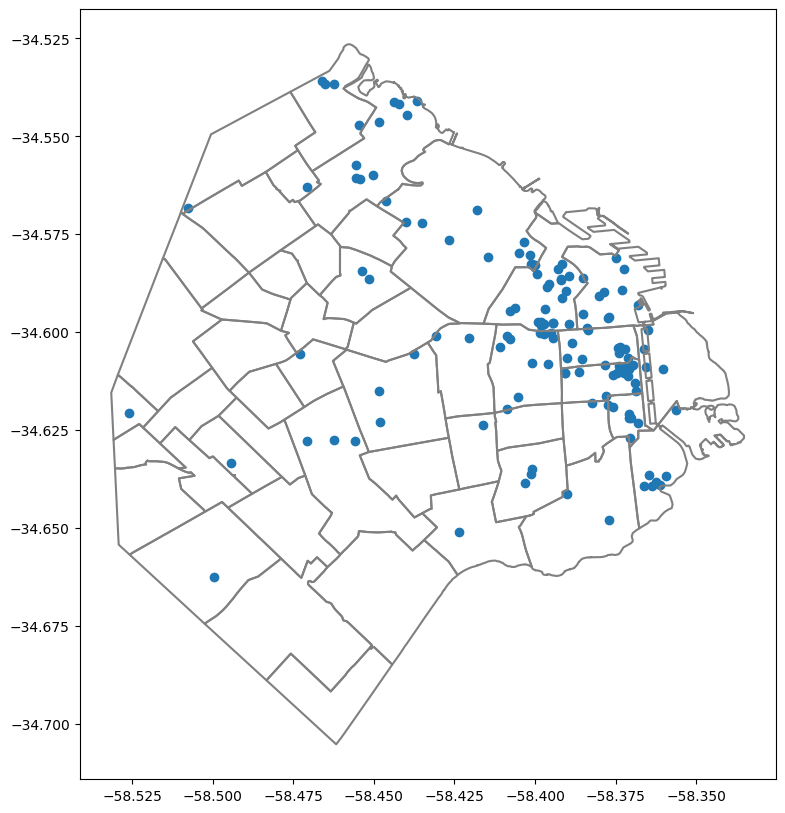

In [9]:
# Armamos el gráfico para visualizar los museos
fig, ax = plt.subplots(figsize=(10, 10))
barrios.boundary.plot(color='gray',ax=ax)
museos.plot(ax=ax)

## Cálculo de la matriz de distancias

Ahora construimos la matriz de distancias entre todos los museos. Como la tierra es un [geoide](https://es.wikipedia.org/wiki/Geoide) (es decir que no es [plana](https://es.wikipedia.org/wiki/Terraplanismo)), el cálculo de distancias no es una operación obvia. Una opción es proyectar a un [sistema de coordenadas local](https://geopandas.org/en/stable/docs/user_guide/projections.html), de forma tal que las distancias euclideas se correspondan con las distancias en metros. En este notebook usamos [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) 22184. 

In [10]:
# En esta línea:
# Tomamos museos, lo convertimos al sistema de coordenadas de interés, extraemos su geometría (los puntos del mapa), 
# calculamos sus distancias a los otros puntos de df, redondeamos (obteniendo distancia en metros), y lo convertimos a un array 2D de numpy
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()

### Matriz de adyacencia: construimos una matriz conectando a cada museo con los $m$ más cercanos

In [11]:
def construye_adyacencia(D,m): 
    # Función que construye la matriz de adyacencia del grafo de museos
    # D matriz de distancias, m cantidad de links por nodo
    # Retorna la matriz de adyacencia como un numpy.
    D = D.copy()
    l = [] # Lista para guardar las filas
    for fila in D: # recorriendo las filas, anexamos vectores lógicos
        l.append(fila<=fila[np.argsort(fila)[m]] ) # En realidad, elegimos todos los nodos que estén a una distancia menor o igual a la del m-esimo más cercano
    A = np.asarray(l).astype(int) # Convertimos a entero
    np.fill_diagonal(A,0) # Borramos diagonal para eliminar autolinks
    return(A)

m = 3 # Cantidad de links por nodo
A = construye_adyacencia(D,m)

## Construcción de la red en NetworkX (sólo para las visualizaciones)

In [12]:
G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
# Construimos un layout a partir de las coordenadas geográficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

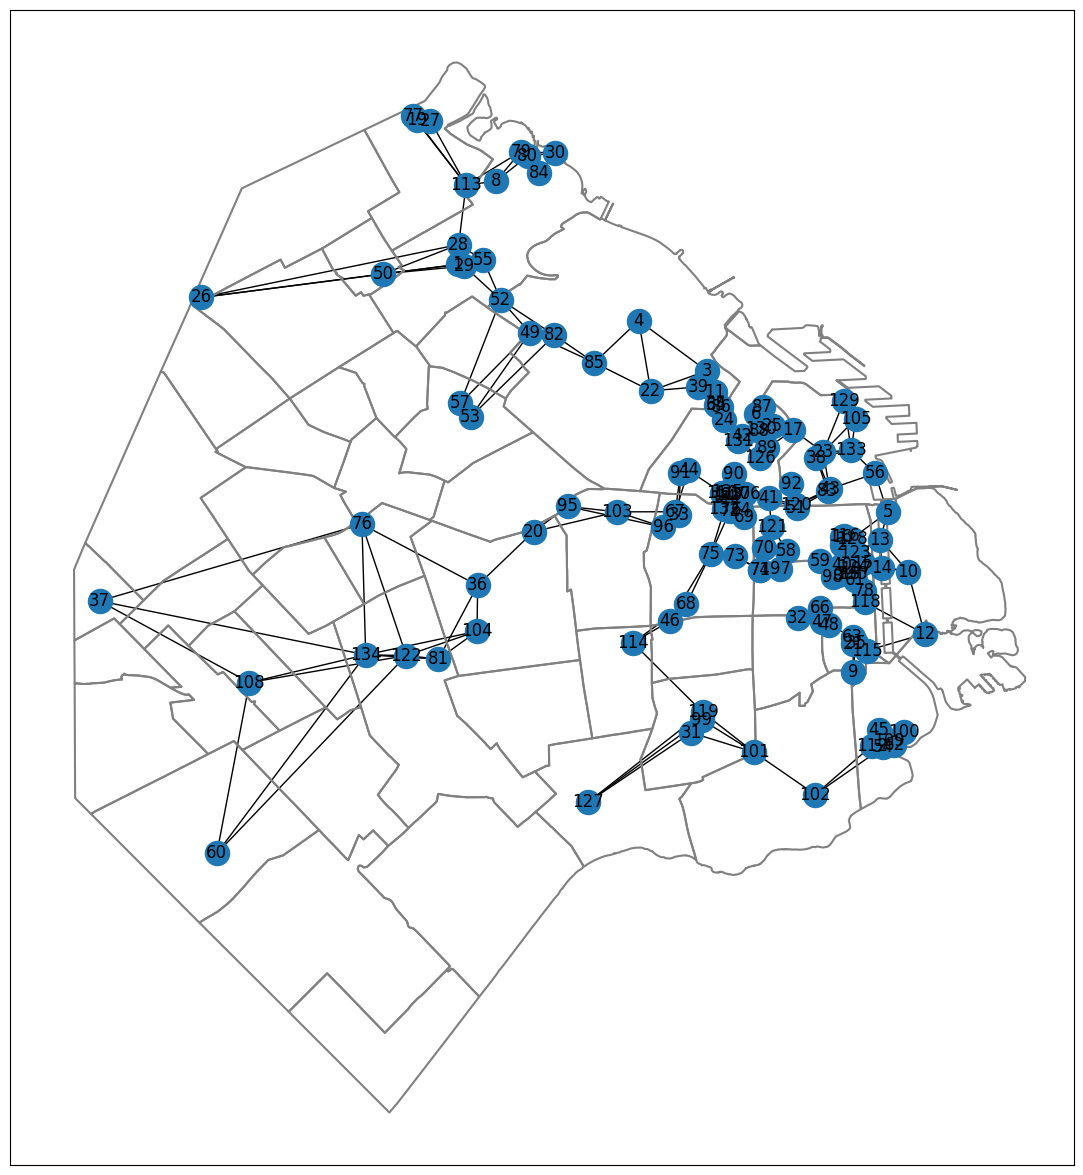

In [13]:
fig, ax = plt.subplots(figsize=(15, 15)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
nx.draw_networkx(G,G_layout,ax=ax) # Graficamos los museos

# Resolución del TP

Aquí empieza la aventura... ¡diviertanse y consulten lo que necesiten!

## Punto 1:

Partamos de la ecuacion siguiente para llegar hacia Mp = b:

1.
$$
p = (1 - \alpha) \cdot C \cdot p + \frac{\alpha}{N} \cdot \mathbf{1}
$$
$$
0 = (1 - \alpha) \cdot C \cdot p - p + \frac{\alpha}{N} \cdot \mathbf{1}
$$
$$
- \frac{\alpha}{N} \cdot \mathbf{1} = (1 - \alpha) \cdot C \cdot p - p
$$
Aca sacamos factor comun usando p 
$$
- \frac{\alpha}{N} \cdot \mathbf{1} = ((1 - \alpha) \cdot C - I) \cdot p 
$$
$$
\frac{\alpha}{N} \cdot \mathbf{1} = -((1 - \alpha) \cdot C - I) \cdot p 
$$
$$
\frac{\alpha}{N} \cdot \mathbf{1} = (I - (1 - \alpha) \cdot C) \cdot p 
$$
$$
\mathbf{1} = \frac{N}{\alpha} \cdot (I - (1 - \alpha) \cdot C) \cdot p   
$$
Por la definicion de M simplemente reemplazamos y llegamos a:
$$
\mathbf{1} = M \cdot p   
$$
9. Entonces llegamos a partir de la formula .1 a que el vector de rankings p es el resultado de Mp = b con b siendo 1 (vector de 1's) y M siendo igual a:
$$
\frac{N}{\alpha} \cdot (I - (1 - \alpha) \cdot C)
$$

## Punto 2:


a) Para que Mp = b tenga una sola solucion entonces las columnas de M deberian ser Linealmente Independientes.

b) Sabemos que M es igual a:
$$
\frac{N}{\alpha} \cdot (I - (1 - \alpha) \cdot C)
$$
Donde N sobre Alpha es un escalar donde N es el tamanio de C y Alpha un numero mayor y menor estricto de 0 y 1 respectivamente, por lo que lo que verdaderamente nos interesa ver para cerciorarnos de que la matriz M tiene solucion unica es la parte de:
$$
(I - (1 - \alpha) \cdot C)
$$
Lo que sabemos de esta parte de la formula es que el escalar de (1 - Alpha) es estrictamente mayor que 0 y menor que uno por la definicion de Alpha dada anteriormente. Luego, sobre C sabemos que es una matriz estocastica, esto quiere decir que la sumatoria de los valores de sus columnas es igual a 1 y que todo valor de la matriz C es positivo. Ahora bien, teniendo esta informacion como podriamos demostrar que la Matriz M tiene solucion unica?
De C, al ser estocastica, podemos deducir que al ser multiplicada por un escalar significa que todos los valores internos de C estan siendo multiplicados por un valor estrictamente menor que 1, por lo cual la matriz C multiplicada por el escalar (llamemosla B) tiene norma 1 estrictamente menor a 1. Esto radica en la definicion de matriz estocastica, donde la sumatoria de las columnas es exactamente 1 (por lo que tiene norma 1) por lo que ahora el valor de su norma al multiplicarla por un numero < 1 podemos asegurar que:
$$
\|\mathbf{B}\|_1 < 1
$$
Teniendo esto en cuenta, tratemos de definir por absurdo que el resultado de la resta (I-B) es inversible, es decir, que es LI y por lo tanto resultado unico de Mp = b.
Supongamos que el resultado de dicha resta NO es LI, esto significa que el Nucleo va a ser de una dimension mayor a 2 ya que vamos a tener mas valores ademas del x = 0 para los cuales:
$$
(I - B) \cdot \mathbf{x} = \mathbf{0} 
$$
Por lo tanto podemos asegurar que existe un x != 0 para el cual el resultado de dicha ecuacion es 0. Por lo cual podemos plantear que:
$$
(I - B)\cdot \mathbf{x} = \mathbf{0} 
$$ 
$$
I\cdot \mathbf{x} - B\cdot \mathbf{x} = 0 
$$ 
$$
\mathbf{x} - B\cdot \mathbf{x} = 0
$$
$$
\mathbf{x} = B\cdot \mathbf{x}
$$
Y terminamos llegando a una igualdad:
$$
\|\mathbf{x}\|_1 = \|\mathbf{Bx}\|_1 
$$
Por propiedad de normas, podemos definir que:
$$
\|\mathbf{Rx}\|_1 <= \|\mathbf{B}\|_1 \cdot \|\mathbf{x}\|_1 
$$
Y ahora reemplazamos
$$
\|\mathbf{x}\|_1 <= \|\mathbf{B}\|_1 \cdot \|\mathbf{x}\|_1 
$$
$$
1 <= \|\mathbf{B}\|_1
$$
ABSURDO! sabiamos que la norma de B era estrictamente menor que 1, este error se debe en que asumimos que (I-B) no era inversible, por lo que al demostrar que la matriz resultado de esta resta es inversible, podemos asegurar que M es inversible.

## Punto 3:

In [14]:
#Funciones que utilizamos
def elim_gaussiana(A):
    m=A.shape[0]
    n=A.shape[1]
    Ac = A.copy()
    
    if m!=n:
        print('Matriz no cuadrada')
        return
    
    for i in range(n - 1):
        for f in range(i + 1, n):
            divisor = Ac[f][i] / Ac[i][i]
            Ac[f][i] = divisor  
            for c in range(i + 1, n):  
                Ac[f][c] = Ac[f][c] - divisor * Ac[i][c]
            
    L = np.tril(Ac,-1) + np.eye(A.shape[0])
    U = np.triu(Ac)
    
    return L, U

def y_calculator(L, b):
    n = L.shape[0]
    y = np.zeros(n)
    for i in range(n):
        value = b[i]
        for j in range(i):
            value = value - L[i][j] * y[j]
        y[i] = value 
    return y

def x_calculator(U, y):
    n = U.shape[0]
    x = np.zeros(n)
    for i in range(n-1,-1,-1):  
        value = y[i]
        for j in range(i+1, n):
            value = value - U[i][j] * x[j]
        x[i] = value / U[i][i]
    return x

def Matriz_M(a,m):
    return (N/a)*(I-(1-a)*C)


In [15]:
#Seteamos las variables que sabemos que son globales y no cambian
N = A.shape[0]
#Armamos K que es la identidad multiplicada por m, como necesitamos la inversa solamente calculamos la inversa de la diagonal
K_inversa = np.eye(N, k=0)*1/m
A_transpueta = A.T
C = A_transpueta @ K_inversa
I = np.eye(N, k=0)

## Punto 3) a.a)

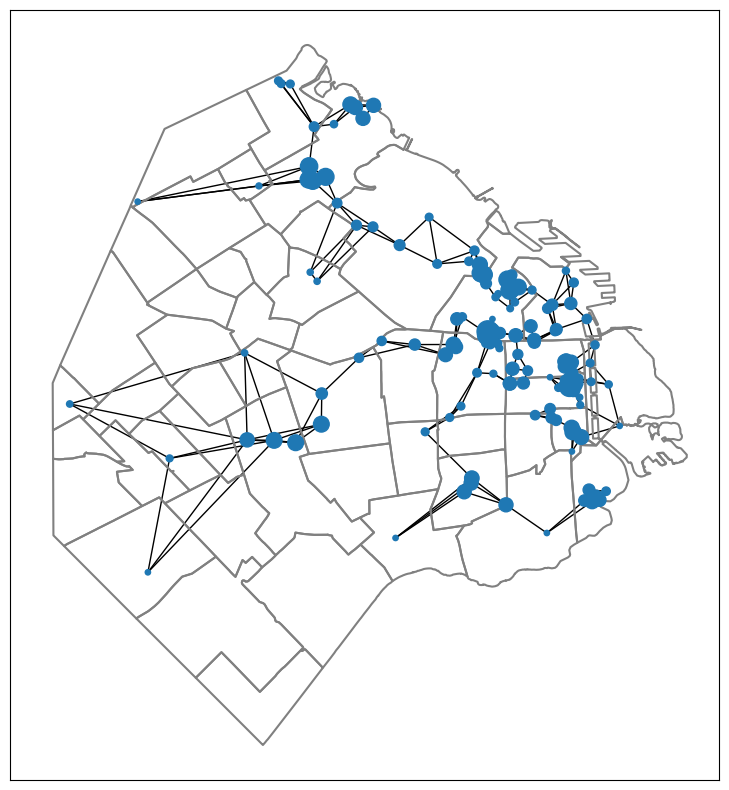

In [16]:
#Aca seteamos el alpha y m para generar la matriz M, luego obtenemos la factorizacion LU de M y resolvemos con las funciones para las matrices trianguladas

alpha_a1 = 1/5
m_a1 = 3
M_a1 = Matriz_M(alpha_a1, m_a1)

L_M, U_M, = elim_gaussiana(M_a1)

b_a1 = np.ones(N)

y_a1 = y_calculator(L_M, b_a1)
p_a1 = x_calculator(U_M, y_a1)
#Aca ya obtenemos el vector de rankings p para alpha = 1/5 y m = 3.


# Y finalmente aca ploteamos el vector p asignando a cada nodo un tamanio proporcional al Page Rank que le toca

factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
fig, ax = plt.subplots(figsize=(10, 10)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
nx.draw_networkx(G,G_layout,node_size = p_a1*factor_escala, ax=ax,with_labels=False) # Graficamos red

## Punto 3) a.b)

## Punto 4:


$w$ = Vector que representa el número total de visitas que recibió cada museo en cada componente.  
$v$ = Vector que representa el número de visitas que recibió cada museo en el punto de partida.

Al realizar producto matricial con la matriz $C$ y el vector $v$, obtengo un vector $v_1$.  
Si se hace la misma aplicación sobre $v_1$ obtengo un $v_2$ con la información de los visitantes en una segunda iteración.  
Este procedimiento se puede repetir $k$ veces de modo que:

$$
v_k = C^k \cdot v
$$

(recordemos la propiedad de asociatividad $C(C \cdot v) = (C \cdot C) \cdot v$)

$w$, al representar el número total de visitas en $r$ iteraciones, se puede describir como la sumatoria de todos los $v$ (desde $0$ a $r-1$).  
Luego:

$$
w = \sum_{k=0}^{r-1} v_k
$$

Sea:

$$
B = \sum_{k=0}^{r-1} C^k
$$

Demostremos que:

$$
v = B^{-1} \cdot w
$$

$$
v = B^{-1} \cdot w \Leftrightarrow B \cdot v = w \Leftrightarrow \left( \sum_{k=0}^{r-1} C^k \right) \cdot v = \sum_{k=0}^{r-1} v_k
$$

pero $v_k = C^k \cdot v$, entonces:

$$
\sum_{k=0}^{r-1} C^k \cdot v = C^0 \cdot v + C^1 \cdot v + C^2 \cdot v + \dots + C^{r-1} \cdot v = (C^0 + C^1 + C^2 + \dots + C^{r-1}) \cdot v = \left( \sum_{k=0}^{r-1} C^k \right) \cdot v
$$


Por lo tanto:

$$
v = B^{-1} \cdot w \quad \blacksquare
$$

## Punto 5:

In [ ]:
w = pd.read_csv('./visitas.txt', sep='\t', encoding='utf-8')
display(visitas)

#a.
def calcula_matriz_C_continua(D):
    f = lng.inv(D)
    sum; 
    for i in range(D.shape[0]):
        for k in range(D.shape[1]):
            if i != k:
                sum += f[i][k]
    return f / sum


#b.
def calcula_B(C,r):
    B = np.zeros((C.shape[0],C.shape[1]))
    for k in range(r):
        B += np.linalg.matrix_power(C,k)
    return B

#c
L_B, U_B, = elim_gaussiana(calcula_B(calcula_matriz_C_continua(D), 3))

#TODO: resolver el LU

,1159
0,1078
1,1137
2,1073
3,1097
4,1083
...,...
130,1115
131,1110
132,1118
133,1156


## Punto 6:

# Extras

Para graficar la red con un conjunto de puntajes (como el Page Rank)

{0: Text(4924405.086723215, 6160838.106023658, ''),
 1: Text(4917216.80489522, 6166701.553530234, ''),
 2: Text(4924486.298584606, 6161409.256658559, ''),
 3: Text(4921922.052887296, 6164690.544542129, ''),
 4: Text(4920636.67547965, 6165640.199444978, ''),
 5: Text(4925338.320928778, 6162016.528710163, ''),
 6: Text(4922856.100832731, 6163868.567721188, ''),
 7: Text(4922641.894255253, 6162355.100129171, ''),
 8: Text(4917938.7521918025, 6168273.372961773, ''),
 9: Text(4924683.52693892, 6158996.617208998, ''),
 10: Text(4925725.9600755945, 6160896.846339954, ''),
 11: Text(4922075.10183836, 6164294.738410278, ''),
 12: Text(4926038.146946977, 6159721.190876993, ''),
 13: Text(4925200.592014585, 6161503.005610317, ''),
 14: Text(4925229.168803978, 6160973.145341254, ''),
 15: Text(4924875.410406244, 6161061.981187101, ''),
 16: Text(4924474.294424794, 6161547.549492302, ''),
 17: Text(4923553.755484842, 6163571.336254905, ''),
 18: Text(4924615.955668659, 6160843.2491330765, ''),
 19:

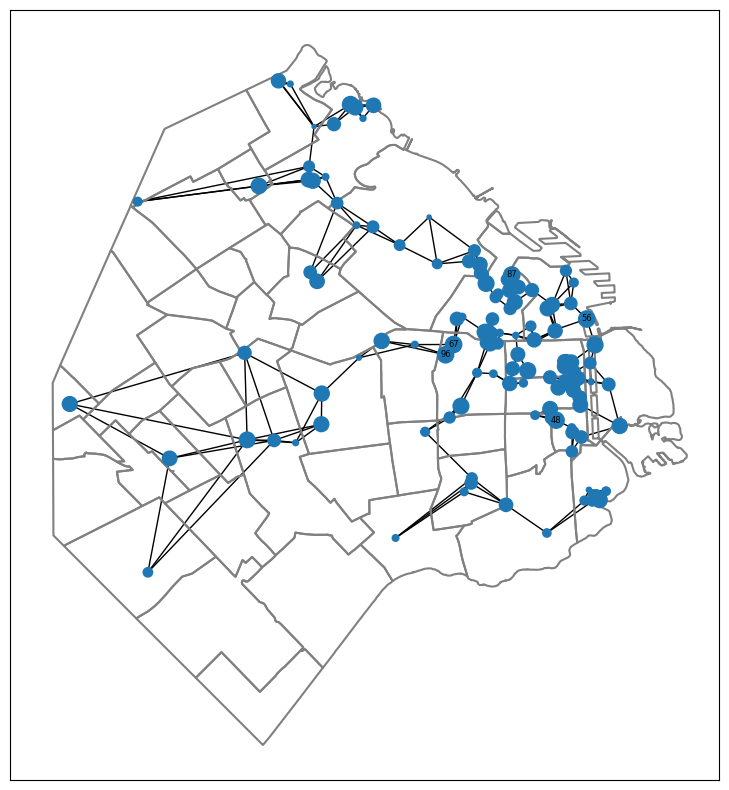

In [ ]:
factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
fig, ax = plt.subplots(figsize=(10, 10)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
pr = np.random.uniform(0,1,museos.shape[0])# Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
pr = pr/pr.sum() # Normalizamos para que sume 1
Nprincipales = 5 # Cantidad de principales
principales = np.argsort(pr)[-Nprincipales:] # Identificamos a los N principales
labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos
nx.draw_networkx(G,G_layout,node_size = pr*factor_escala, ax=ax,with_labels=False) # Graficamos red
nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="k") # Agregamos los nombres